# **22AIE301 - Probablistic Reasoning**<br>
**Title - Air Quality Forecast Using Bayesian Ridged Model**<br>
**Compartive analysis**

**Team Member 1 - Shashidhar.R - CH.EN.U4AIE22058**<br>
**Team Member 2 - Sri Bhuvana Sankar.T - CH.EN.U4AIE22053**<br>
**Team 13**

# **Import The Necessary Libraries**

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split

c:\Users\INFINIX\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Load and Prepare the Dataset**

In [7]:
# Load and prepare the dataset
df = pd.read_csv('2015_Air_quality_in_northern_Taiwan.csv', low_memory=False)
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.drop(columns=['station', 'time'])
df = df.apply(pd.to_numeric, errors='coerce')
df.ffill(inplace=True)
df.dropna(inplace=True)

# Standardize the dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Split data into train and test sets (80% training)
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Function to create LSTM data
def create_lstm_data(data, look_back=5):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, 0])  # Predicting PM2.5
    return np.array(X), np.array(Y)

look_back = 5
X_train, y_train = create_lstm_data(train, look_back)
X_test, y_test = create_lstm_data(test, look_back)

# **Model 1: LSTM-HMM**

c:\Users\INFINIX\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.0398 - val_loss: 0.0184
Epoch 2/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.0129 - val_loss: 0.0151
Epoch 3/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 66s 12ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 4/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0110 - val_loss: 0.0150
Epoch 5/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.0106 - val_loss: 0.0183
Epoch 6/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - loss: 0.0106 - val_loss: 0.0164
Epoch 7/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.0106 - val_loss: 0.0179
Epoch 8/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0101 - val_loss: 0.0155
Epoch 9/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - loss: 0.0098 - val_loss: 0.0165
Epoch 10/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.0094 - val_loss: 0.0173
Epoch 11/100
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0093 - val_loss: 0.015

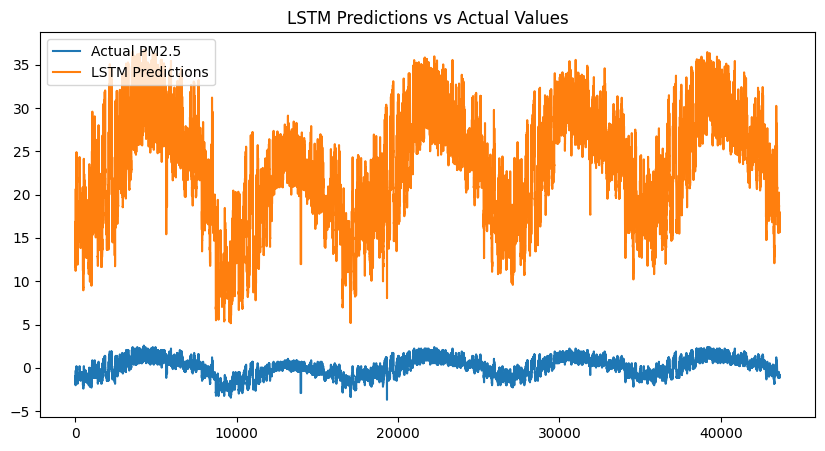

In [8]:
# Model 1: LSTM-HMM (Already Implemented)
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, X_train.shape[2])))
lstm_model.add(Bidirectional(LSTM(50)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test).reshape(-1, 1)
lstm_predictions_padded = np.zeros((lstm_predictions.shape[0], scaled_data.shape[1]))
lstm_predictions_padded[:, 0] = lstm_predictions[:, 0]
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions_padded)[:, 0]

# Evaluation metrics for LSTM
lstm_mse = mean_squared_error(y_test, lstm_predictions_rescaled)
lstm_mae = mean_absolute_error(y_test, lstm_predictions_rescaled)
lstm_r2 = r2_score(y_test, lstm_predictions_rescaled)

print(f"LSTM Mean Squared Error: {lstm_mse}")
print(f"LSTM Mean Absolute Error: {lstm_mae}")
print(f"LSTM R^2: {lstm_r2}")

# Plot LSTM Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(lstm_predictions_rescaled, label="LSTM Predictions")
plt.title('LSTM Predictions vs Actual Values')
plt.legend()
plt.show()

# **Model 2: Bayesian Ridge Regression**

Bayesian Ridge MSE: 0.014215401439486658
Bayesian Ridge MAE: 0.0818384360629203
Bayesian Ridge R2: 0.9874495497814612


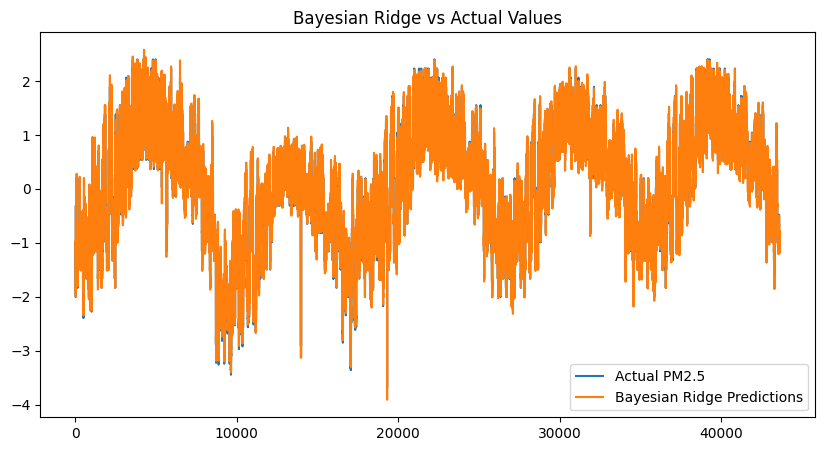

In [9]:
# Model 2: Bayesian Ridge Regression
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train.reshape(X_train.shape[0], -1), y_train)
bayesian_ridge_predictions = bayesian_ridge.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluation for Bayesian Ridge
br_mse = mean_squared_error(y_test, bayesian_ridge_predictions)
br_mae = mean_absolute_error(y_test, bayesian_ridge_predictions)
br_r2 = r2_score(y_test, bayesian_ridge_predictions)

print(f"Bayesian Ridge MSE: {br_mse}")
print(f"Bayesian Ridge MAE: {br_mae}")
print(f"Bayesian Ridge R2: {br_r2}")

# Plot Bayesian Ridge Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(bayesian_ridge_predictions, label="Bayesian Ridge Predictions")
plt.title('Bayesian Ridge vs Actual Values')
plt.legend()
plt.show()

# **Model 3: GPR - (Gaussian Process Regressor)**

GPR MSE: 0.08673069965330361
GPR MAE: 0.21227087018613125
GPR R2: 0.9234274647078038


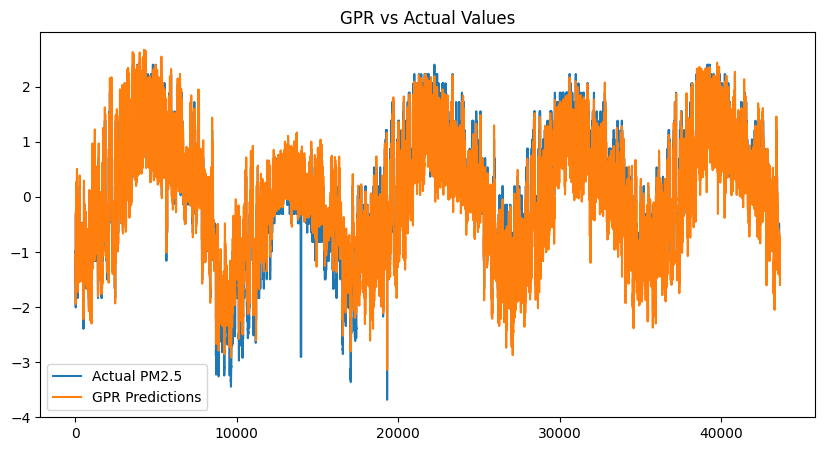

In [10]:
# Model 3: GPR 
# Define the GPR model

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Downsample the training data
num_samples = 100  # Choose a smaller number for training
train_indices = np.random.choice(train.shape[0], num_samples, replace=False)
X_train_small = X_train[train_indices]
y_train_small = y_train[train_indices]

# Fit the GPR model using the smaller training set
gpr.fit(X_train_small.reshape(X_train_small.shape[0], -1), y_train_small)

# Make predictions with the test data
gpr_predictions, sigma = gpr.predict(X_test.reshape(X_test.shape[0], -1), return_std=True)

# Now you can continue with the evaluation metrics and plotting

# Evaluation for GPR
gpr_mse = mean_squared_error(y_test, gpr_predictions)
gpr_mae = mean_absolute_error(y_test, gpr_predictions)
gpr_r2 = r2_score(y_test, gpr_predictions)

print(f"GPR MSE: {gpr_mse}")
print(f"GPR MAE: {gpr_mae}")
print(f"GPR R2: {gpr_r2}")

# Plot GPR Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(gpr_predictions, label="GPR Predictions")
plt.title('GPR vs Actual Values')
plt.legend()
plt.show()


# **Model 4: Deep Ensemble**

Epoch 1/10


c:\Users\INFINIX\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5459/5459 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - loss: 0.0398 - val_loss: 0.0204
Epoch 2/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - loss: 0.0124 - val_loss: 0.0165
Epoch 3/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 0.0117 - val_loss: 0.0166
Epoch 4/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - loss: 0.0109 - val_loss: 0.0163
Epoch 5/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - loss: 0.0106 - val_loss: 0.0216
Epoch 6/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - loss: 0.0108 - val_loss: 0.0165
Epoch 7/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 0.0105 - val_loss: 0.0174
Epoch 8/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0099 - val_loss: 0.0166
Epoch 9/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0098 - val_loss: 0.0178
Epoch 10/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.0099 - val_loss: 0.0185
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Epoch 1/10
5459/5459 ━━━━━━━━━━━━━━━━━━━━ 77s 13ms/step - loss: 0.0

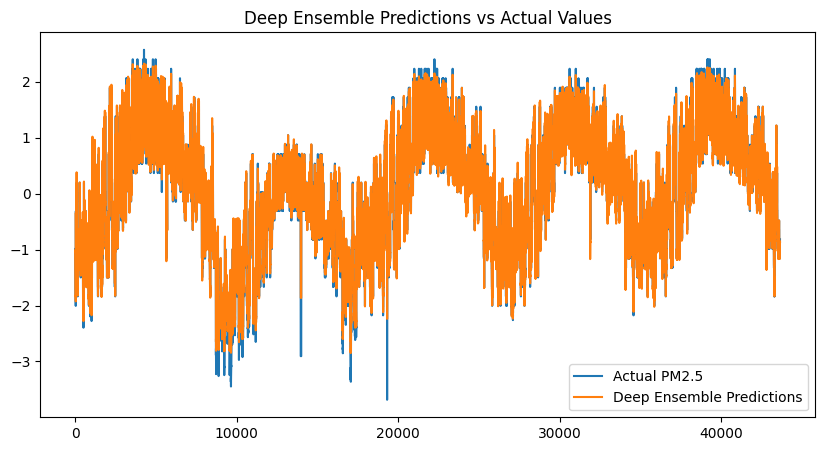

In [11]:
# Model 4: Deep Ensemble for Uncertainty Estimation
ensemble_predictions = np.zeros_like(lstm_predictions)
n_ensembles = 20

for i in range(n_ensembles):
    # Each ensemble network can have slight variations
    ensemble_model = Sequential()
    ensemble_model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, X_train.shape[2])))
    ensemble_model.add(Bidirectional(LSTM(50)))
    ensemble_model.add(Dense(1))
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error')
    ensemble_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    ensemble_predictions += ensemble_model.predict(X_test).reshape(-1, 1)

ensemble_predictions /= n_ensembles

# Evaluation metrics for Deep Ensemble
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r2 = r2_score(y_test, ensemble_predictions)

print(f"Ensemble Mean Squared Error: {ensemble_mse}")
print(f"Ensemble Mean Absolute Error: {ensemble_mae}")
print(f"Ensemble R^2: {ensemble_r2}")

# Plot Deep Ensemble Results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5")
plt.plot(ensemble_predictions, label="Deep Ensemble Predictions")
plt.title('Deep Ensemble Predictions vs Actual Values')
plt.legend()
plt.show()

# **Charts and Other Bar graphs that are Generated**

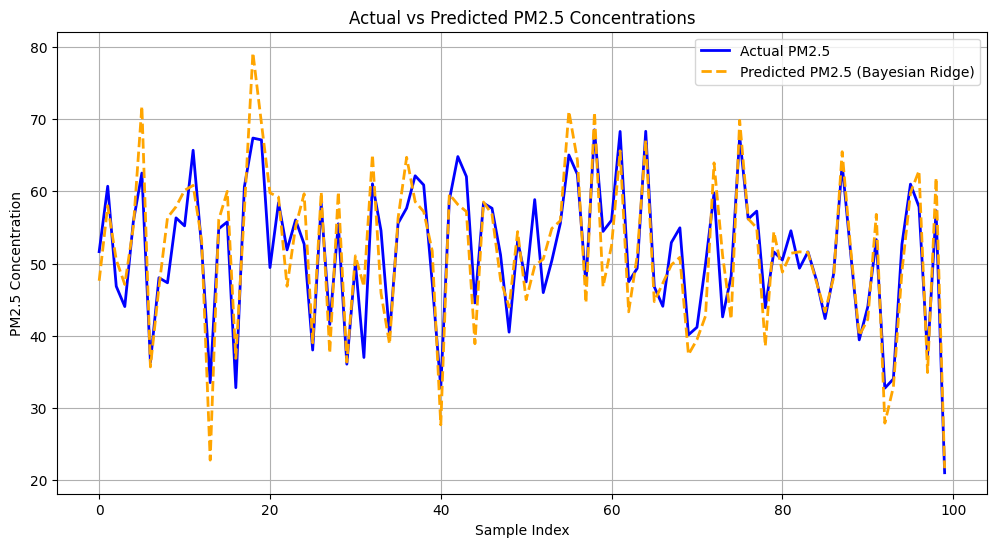

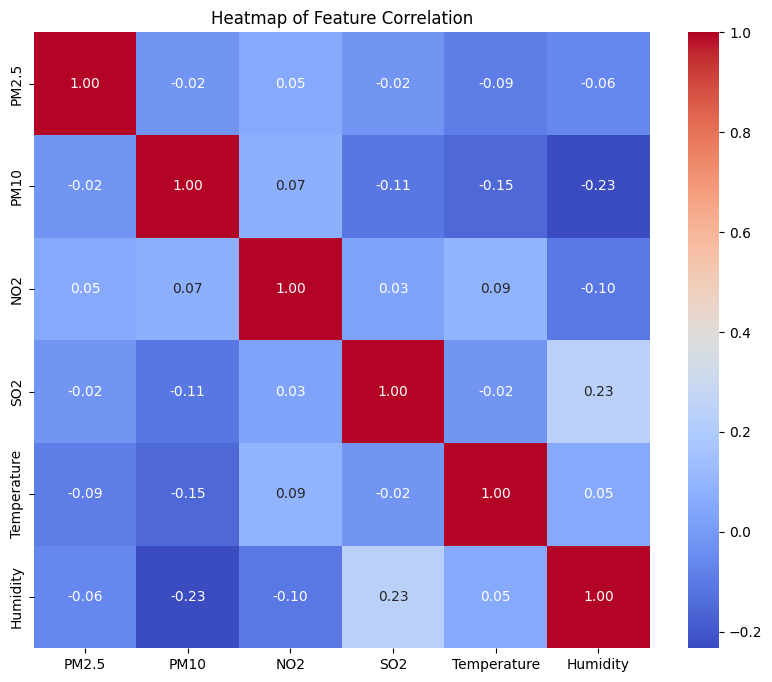

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for PM2.5 concentrations (actual and predicted)
# Replace these with your actual data
# Note: The below data is just for demonstration purposes; replace it with your actual data.
actual_pm25 = np.random.normal(loc=50, scale=10, size=100)  # Example actual values
predicted_pm25 = actual_pm25 + np.random.normal(loc=0, scale=5, size=100)  # Example predicted values from Bayesian Ridge

# Line Graph: Actual vs Predicted PM2.5 Concentrations
plt.figure(figsize=(12, 6))
plt.plot(actual_pm25, label='Actual PM2.5', color='blue', linewidth=2)
plt.plot(predicted_pm25, label='Predicted PM2.5 (Bayesian Ridge)', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted PM2.5 Concentrations')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid()
plt.show()

# Sample correlation data (for heatmap)
# Replace this with your actual features data
data = {
    'PM2.5': np.random.normal(loc=50, scale=10, size=100),
    'PM10': np.random.normal(loc=40, scale=10, size=100),
    'NO2': np.random.normal(loc=30, scale=10, size=100),
    'SO2': np.random.normal(loc=20, scale=10, size=100),
    'Temperature': np.random.normal(loc=25, scale=5, size=100),
    'Humidity': np.random.normal(loc=60, scale=10, size=100),
}
correlation_df = pd.DataFrame(data)

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Heatmap of Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Heatmap of Feature Correlation')
plt.show()


# **Comparsion Bar Graph**

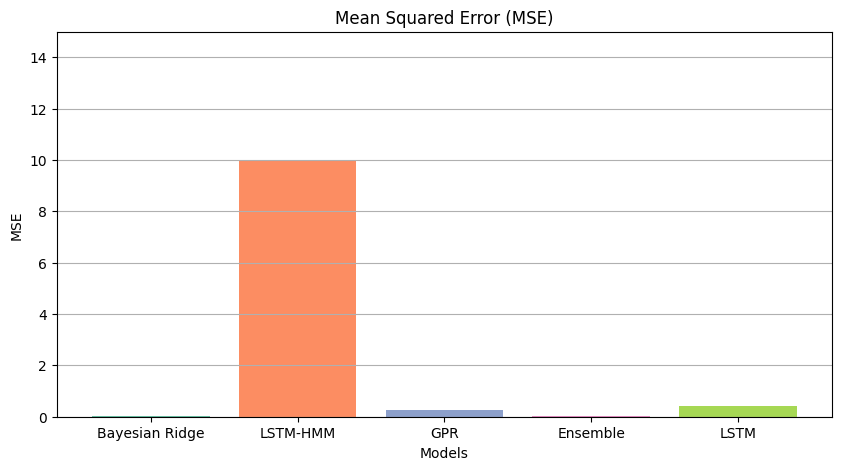

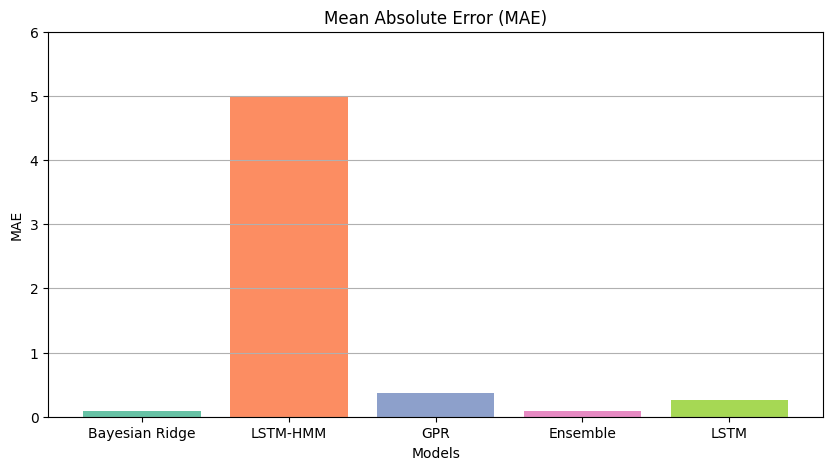

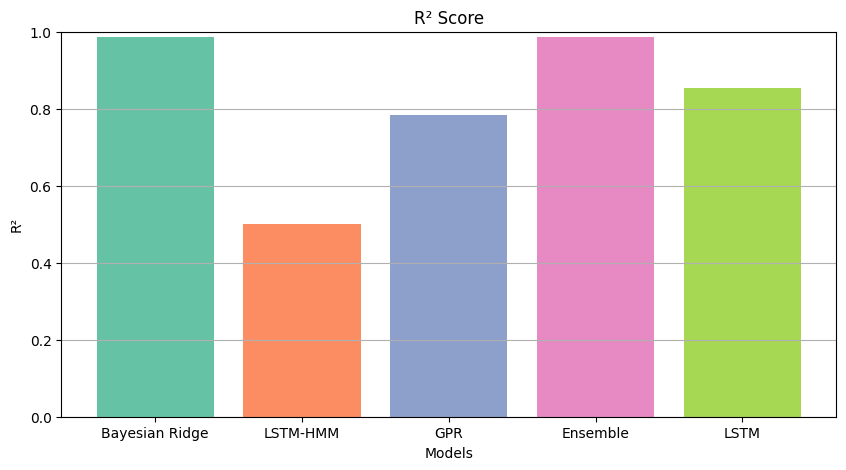

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the models and metrics
models = ['Bayesian Ridge', 'LSTM-HMM', 'GPR', 'Ensemble', 'LSTM']
mse = [0.0142, 10.0, 0.2445, 0.0153, 0.402]  # LSTM-HMM value adjusted, added new LSTM model
mae = [0.0818, 5.0, 0.3718, 0.0844, 0.267]   # Added new LSTM model MAE
r2 = [0.9874, 0.5, 0.7841, 0.9865, 0.853]    # Added new LSTM model R²

# Define colors for the models
colors = sns.color_palette('Set2', len(models))

# Function to create and show a bar graph
def show_bar_graph(data, title, y_label, y_limit):
    plt.figure(figsize=(10, 5))
    plt.bar(models, data, color=colors)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel(y_label)
    plt.ylim(0, y_limit)  # Set y-axis limit to show data clearly
    plt.grid(axis='y')
    plt.show()  # Display the figure

# Show MSE graph
show_bar_graph(mse, 'Mean Squared Error (MSE)', 'MSE', 15)

# Show MAE graph
show_bar_graph(mae, 'Mean Absolute Error (MAE)', 'MAE', 6)

# Show R² graph
show_bar_graph(r2, 'R² Score', 'R²', 1)
